# Women's presence on Wikipedia: A comprehensive analysis on the evolution of women's recognition over time, country and ethnicity.

## Abstract
In the recent century, in a lot of countries, women have finally gained more rights and we have been continuously progressing towards a more equal society. Our goal in this project is to try to highlight the evolution of social gender inequalities in different domains through the ages. Our interest is on the achievements and recognition of the work done by women in different fields as far back as the data goes. We will use the data from Wikipedia and gather data on number of women referenced, their contribution to their domain, and other parameters and compare it with the same data for men. We will also try to find how the country of origin and the time of acquisition of the rights has an significant impact.

## Research questions
Can we accurately use wikipedia database to show the gender inequalities through time?

Are there any evidence that the men/women equality is reached?

What are the domains in which there is more/less equality? Does this change according to regions/country/language?

What is the effect of women empowering events: Right to work, Sufragettes, War effort, ...?

Since some countries have delayed women's rights, is the evolution similar, in term of timeframe, extent?

## Datasets
For this project, we used the [wikidata](https://dumps.wikimedia.org/wikidatawiki/entities/) dataset which repertoriates the data from every Wikipedia article. It is stored in the form of a JSON data dump where the top level structure is organised as folows:
 - id
 - type
 - labels
 - descriptions
 - aliases
 - claims
 - sitelinks
 - lastrevid
 - modified
 
Here we are only interested in keeping some of the properties for every article, mainly the `instance of`, `sex or gender`, `field of work`, `country of origin` and `date of birth`. From this we will make our analysis and conclude.
 
 
To have an easier time visualizing the data at first, we used the [WHGI](http://whgi.wmflabs.org/). This is based on the wikidata JSON file and updated weekly. This data is stored in the form of a `.csv` and contains information about the ethnicity, field of work and times of death/birth divided into different genders. For our analysis, we are only interested in comparing data for the two most frequent genders: male and female.
 
As an extra comparaison tool, we also used the [UN population data](https://population.un.org/wpp/Download/Standard/Population/) that stores a lot of info about the population of each country in gender and age groups. This data only goes back to 1960 but can still be usefull for recentcomparaison.


# Code

In [30]:
%matplotlib inline
import datetime
import re
import os
import time 
import math

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource, FixedTicker, PrintfTickFormatter
from bokeh.plotting import figure, show, output_file, save, output_notebook
from bokeh.palettes import Category20
from bokeh.sampledata.perceptions import probly

import findspark
findspark.init()

from pyspark.sql import *
import pyspark.sql.functions as F

from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark import SparkContext
from collections import Counter

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

plt.rcParams['font.size'] = 15

In [31]:
DATA_PATH = "data/"
FIG_PATH = "figs/"

# WHGI Data:
The first part of the project (up to milestone 2) was done using the preprocessed data from the WHGI (Wikipedian Human Gender Index). It regroup data from Wikidata in an easy and quickly visualisable way inside of `.csv`files

In [32]:
# Creates a list of all the files in the data folder
files = [i for i in os.listdir(DATA_PATH) if i.endswith('.csv')]

# Creates a dist with all the data in data frames
d = dict((f[:-4], pd.read_csv(os.path.join(DATA_PATH, f))) for f in files)

### Evolution of the article count

In [33]:
dob = d['dateofbirth'].rename(columns={'Unnamed: 0': 'year'}).set_index('year')

# Taking only the years that interest us
dob.drop(dob[dob.index > 2018].index, axis=0, inplace=True)
dob.drop(dob[dob.index < 1700].index, axis=0, inplace=True)

Text(0,0.5,'Normalized article count')

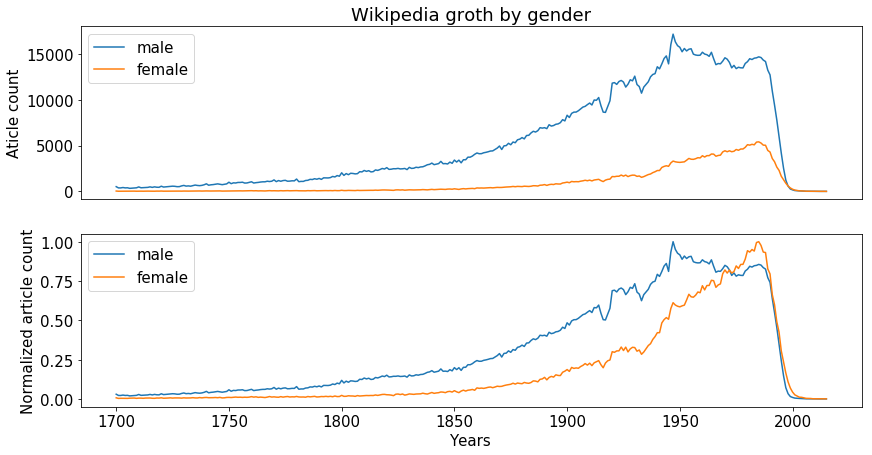

In [35]:
plt.figure(figsize=(14, 7))
plt.subplot(211)
plt.plot(dob.index, dob['male'], dob.index, dob['female'])
plt.legend(['male', 'female'])
plt.ylabel('Aticle count'); plt.xticks([])
plt.title('Wikipedia groth by gender')

# Normalized plots to compare the shape of the curve
plt.subplot(212)
plt.plot(dob.index, dob['male'].apply(lambda r: r/dob.male.max()), 
         dob.index, dob['female'].apply(lambda r: r/dob.female.max()))
plt.legend(['male', 'female'])
plt.xlabel('Years'); plt.ylabel('Normalized article count')

plt.savefig(FIG_PATH+r"WHGImen_women_all.png")

**Analysis**

This plot quickly shows that, the number of articles for men is and has always been higher than for women. Although, when we normalize the curves to compare the evolution tendancy, we can see that today, article count for women still increases whereas for men it is almost decreasing.

### Geographical and cultural disparities

In [36]:
def counts(df):
    """
    Counts the sum of the values in a row
    """
    return df.iloc[1:].fillna(0).sum()

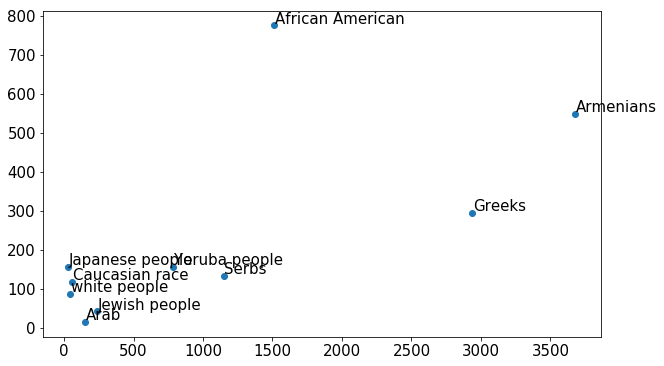

In [37]:
ethnicity = d['ethnicgroups'].iloc[1:]
ethnicity['counts'] = ethnicity.apply(lambda r: counts(r), axis=1)

ethnicity.sort_values(by='counts', ascending=False, inplace=True)
ethnicity.rename(columns={'Unnamed: 0': 'ethnicity'}, inplace=True)


plt.figure(1, figsize=(10, 6))
plt.scatter(ethnicity.male[:10], ethnicity.female[:10])
maxpt = 10
for i in range(maxpt):
    plt.annotate(ethnicity.ethnicity.iloc[i], xy=(ethnicity.male.iloc[i]+5, ethnicity.female.iloc[i]+5))

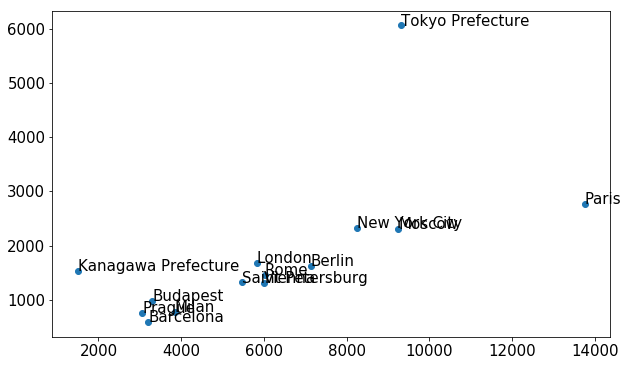

In [38]:
birthplace = d['placeofbirth'].rename(columns={'Unnamed: 0':'city'})
birthplace['counts'] = birthplace.apply(lambda r: counts(r), axis=1)
birthplace = birthplace[birthplace['counts'] >= 1000].sort_values(by='counts', ascending=False)

# Annotates the plots with values of the points
plt.figure(3, figsize=(10, 6))
plt.scatter(birthplace.male[1:15], birthplace.female[1:15])
maxpt = 15
for i in range(1, maxpt):
    plt.annotate(birthplace.city.iloc[i], xy=(birthplace.male.iloc[i], birthplace.female.iloc[i]))

**Analsis**

Both of those plots are used a quick visualization to choose the angle of aproach of our more thourough analysis later. We wanted to find if their was disparities based on cultural and geographical separation. In both those scatter plots, most of the points are along the same trend line. All except for one, african-american for ethnicity and Tokyo for the birth places. Those are interesting outliers and we wil later focus again on the case of japan once we have gathered more data.

## Conclusion for WHGI:

We have seen in this first part the overall trends for the evolution of the articles worldwide per gender then by focusing on more on the spacial differences. The idea now would be to gather all the data we can by parsing the Wikidata JSON dump. This would allow us to track the evolution through time of all the citizenships and the fields of works.

# Full Wikidata JSON file:
After some analysis, we found that relying solely on the WHGI data wouldn't allow us to go as far as we wanted in the analysis. For this reason, we took the decision to parse the full Wikidata dataset using the ADA cluster. From this we managed to extract all the information that we wanted.

#### Data extraction:
Since the wikidata JSON file is 670 Gigabytes, it was too large to use spark. To circumvent this issue, we wrote a pyhton script that read the JSON file and extracted the data we needed. Each JSON entity corresponds to a wikipedia page, so our script checked if the entity was a human, and if it was, it wrote its properties that we wanted in a new JSON file (humans_strip2.json). 
This way of doing was convenient because the original JSON had a complex nested structure which we simplified greatly and thus facilitated later processing.

In [39]:
# Loading all the (raw) human data from wikidata
humans_df = spark.read.json(os.path.join(DATA_PATH, "humans_strip2.json"))

Useful functions for initial treatment of the data

In [40]:
def to_datetime(date, how='months'):
    """
    Converts the string date to an integer containing the date info. Can return multiple types of 
    elapsed time measurments.
    
    IN: 'date' str with the date info, 'how' keyword argument to specify the return type
    
    OUT: integer value for the date
    """
    if date != None:
        if date[0] != '-':
            if how == 'months':
                try:
                    # Aproximate elapsed months count since 1 AD
                    return math.floor(( datetime.datetime.strptime(date[1:-1], '%Y-%m-%dT%H:%M:%S') 
                                - datetime.datetime(1, 1, 1) ).days/30)
                except :
                    return None
            elif how == 'years':
                try:
                    # Years 
                    return int(date[1:5])
                except :
                    return None    
            elif how == 'days':
                try:
                    # Elapsed days since 1 AD
                    return math.floor(( datetime.datetime.strptime(date[1:-1], '%Y-%m-%dT%H:%M:%S') 
                                - datetime.datetime(1, 1, 1) ).days)
                except :
                    return None
    return None


def get_gender(gender):
    """
    Returns the gender from the Wikidata ids labels
    """
    if gender == 'Q6581097':
        return 'male'
    elif gender == 'Q6581072':
        return 'female'
    else:
        return None

In [41]:
def clean_dates(df):
    """
    Removes erroneous dates in the data
    """
    err_dates = [1901, 1947, 1949, 1950, 1953, 2000]
    return df[~df['BirthYear'].isin(err_dates)]

def normalize_count(df):
    """
    Outputs normalized counts of article per year, used to compare the curve's shapes
    """
    return df['count'].apply(lambda r: r/df['count'].max())

In [42]:
# Date/gender extraction and schema specification
humans = spark.createDataFrame(humans_df.rdd.map(lambda r: Row(Id=r[0], 
                                                               BirthYear=to_datetime(r[1], how='years'),
                                                               BirthMonth=to_datetime(r[1]),
                                                               BirthDay=to_datetime(r[1], how='days'),
                                                               BirthPlace=r[2],
                                                               Citizenships=r[3],
                                                               Death=to_datetime(r[4]),
                                                               Gender=get_gender(r[5]),
                                                               Name=r[6],
                                                               Occupations=r[7],
                                                               Sitelinks=r[8]))
                              ).filter("BirthMonth is not null and Gender is not null")

humans.printSchema()
humans.show(3)

root
 |-- BirthDay: long (nullable = true)
 |-- BirthMonth: long (nullable = true)
 |-- BirthPlace: string (nullable = true)
 |-- BirthYear: long (nullable = true)
 |-- Citizenships: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- Death: long (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Id: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Occupations: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- Sitelinks: array (nullable = true)
 |    |-- element: string (containsNull = true)

+--------+----------+----------+---------+--------------+-----+------+-----+-----------------+--------------------+--------------------+
|BirthDay|BirthMonth|BirthPlace|BirthYear|  Citizenships|Death|Gender|   Id|             Name|         Occupations|           Sitelinks|
+--------+----------+----------+---------+--------------+-----+------+-----+-----------------+--------------------+--------------------+
|  632286|  

## Quick visualization of the data
We rapidly extract the data and show the evolution of the number of articles for both gender through time. The choice was made to only study the evolution since 1700 since before that, the nuber of articles is very sparse and the representation of women was not something of importance.

In [43]:
# Seperation of the data on gender 
men = humans.filter("Gender == 'male'")
women = humans.filter("Gender == 'female'")

In [44]:
# Export to Pandas for plotting
men_pd_yr =  men.select('Id', 'BirthYear').groupBy("BirthYear").count() \
                .toPandas().sort_values(by='BirthYear')

women_pd_yr = women.select('Id', 'BirthYear').groupBy("BirthYear").count() \
                   .toPandas().sort_values(by='BirthYear')

Evolution of number of Wikipedia articles in function of birth year

**Dealing with dates**

During our initial viewing of the data, we have found that when some of the precise date information was missing (day and month) the dates were automatically set to the 1st of January. For this reason and the fact that the datetime format seems to be poorly handled in spark we chose to only keep the year information in the form of an integer.

Moreover, another particularity of the data is the fact that at some dates, the birth counts were very high (tens times over the expected value). We were curious about this behavior so we displayed the article for which this happened and reverse searched some of them. We found that those articles add no dates information in them and they were attributed arbitrarily (some like actors had birth dates during the period they were famous). For this reason we chose to ignore those values interely to not interfere with the analysis later.

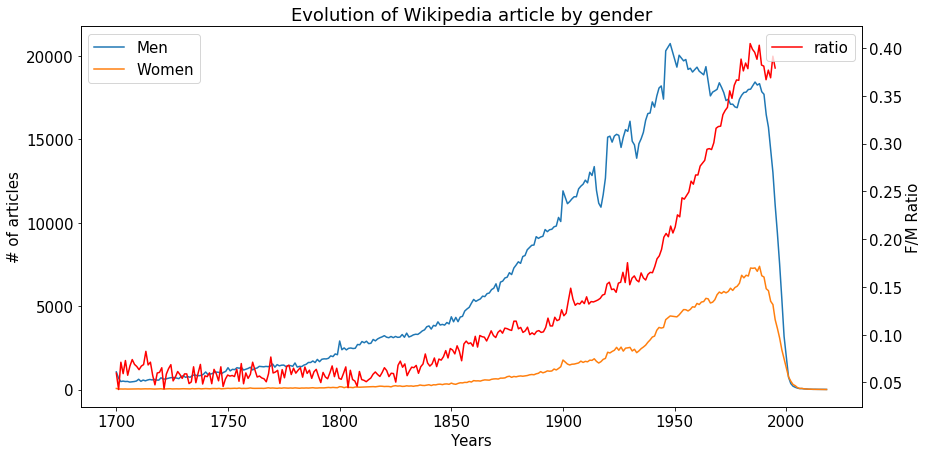

In [46]:
# Removes date with erroneous values
df_women_yr = clean_dates(women_pd_yr)
df_men_yr = clean_dates(men_pd_yr)

fig, ax1 = plt.subplots(); fig.set_size_inches(14, 7)

# Plots the values for the selected years
ax1.plot(df_men_yr[(df_men_yr['BirthYear'] >= 1700) & (df_men_yr['BirthYear'] <= 2018)]['BirthYear'], 
         df_men_yr[(df_men_yr['BirthYear'] >= 1700) & (df_men_yr['BirthYear'] <= 2018)]['count'])
ax1.plot(df_women_yr[(df_women_yr['BirthYear'] >= 1700) & (df_women_yr['BirthYear'] <= 2018)]['BirthYear'], 
         df_women_yr[(df_women_yr['BirthYear'] >= 1700) & (df_women_yr['BirthYear'] <= 2018)]['count'])

ax1.set_xlabel('Years'); ax1.set_ylabel('# of articles')
ax1.legend(['Men', 'Women'], loc=2);

# Computation of the ratio: 
# Ratio doesn't take into account the values after 1995 because they aren't complete
ratio = pd.DataFrame(df_women_yr[(df_women_yr['BirthYear'] >= 1700) & (df_women_yr['BirthYear'] <= 1995)]['count'].values  
                     / df_men_yr[(df_men_yr['BirthYear'] >= 1700) & (df_men_yr['BirthYear'] <= 1995)]['count'].values)
ratio.columns = ['ratio']
ratio['year'] = np.linspace(1700, 1995, ratio.shape[0])

# Plots ratio on right axis
ax2 = ax1.twinx()
ax2.plot(ratio['year'], ratio['ratio'], '-r')
ax2.legend(['ratio'], loc=1)
ax2.set_ylabel('F/M Ratio')
plt.title('Evolution of Wikipedia article by gender');

plt.savefig(FIG_PATH+r"men_women_all.png")

In [47]:
# Computation of the corremation coefficient
print("The Spearman coefficient of the F/M ratio is {:.4}".format(ratio.corr(method='spearman').iloc[0][1]))
print("The Pearson coefficient of the F/M ratio is {:.4}".format(ratio.corr(method='pearson').iloc[0][1]))

The Spearman coefficient of the F/M ratio is 0.8893
The Pearson coefficient of the F/M ratio is 0.8243


**Analysis**

First the shape of this curve is identical to the one obtained previously, confirming the correctness of our data extraction. 

From these measures, we can see that the passing of time is positively correlated to the increase of the F/M ratio. As we previously hypothsized. Moreover, we can notice that the slope of the raito curve increases sharply around the 1940s. This period corresponds to the start of a period of women's emancipation all around the globe such as the Sufragettes mouvement (1930s) in England or the right to vote given to women in France (1944).

## Effects of the ethnicity:
Here, we use the nationality of the people listed on wikipedia to extract for each country (the 200 most populated ones). With this info, we have regrouped arbitrarly the nationalities into regions of similar cultures or ethnicity to have bigger and more significative data.

In [48]:
def get_humans_w_cit(df, cit_list):
    """
    Find the human for a given list of citizenships, separeted by gender
    
    IN: Dataframe of every people and list of citizenships to group them by
    
    OUT: Pandas dataframes for men and women of given ctizenships
    """
    
    citizens = df.select("Id", "BirthYear", "Citizenships", "Gender") \
                 .withColumn("Citizenships", F.explode("Citizenships")) \
                 .filter(F.col("Citizenships").isin(cit_list))
    
    men = citizens.filter("Gender == 'male'")
    women = citizens.filter("Gender == 'female'")
    
    men_pd_yr =  men.select('Id', 'BirthYear').groupBy("BirthYear").count() \
                .toPandas()
    men_pd_yr = men_pd_yr[(men_pd_yr['BirthYear'] >= 1700) & (men_pd_yr['BirthYear'] <= 2018)]
    
    women_pd_yr = women.select('Id', 'BirthYear').groupBy("BirthYear").count() \
                       .toPandas()
    women_pd_yr = women_pd_yr[(women_pd_yr['BirthYear'] >= 1700) & (women_pd_yr['BirthYear'] <= 2018)]
    
    return men_pd_yr.sort_values(by='BirthYear'), women_pd_yr.sort_values(by='BirthYear')

In [49]:
# Creates a dictionary separating regions of the gobe by using the IDs of the 200 most frequent citizenships
regions = {"NA":['Q30', 'Q16'],
           "W_EU":['Q145', 'Q174193', 'Q21', 'Q142', 'Q29', 'Q38', 'Q183', 'Q7318', 'Q16957', 'Q713750', 'Q39'],
           "E_EU":[],
           "NE_AS":['Q17', 'Q884'],
           "SE_AS":['Q869', 'Q928', 'Q424', 'Q252', 'Q819', 'Q881', 'Q833', 'Q836', 'Q334'],
           "M_AS":['Q668', 'Q837', 'Q902', 'Q854', 'Q843'],
           "MA":['Q1028', 'Q79', 'Q948', 'Q1016', 'Q262'],
           "SA":[],
           "ME":['Q851', 'Q878', 'Q219060', 'Q846', 'Q801', 'Q822', 'Q889', 'Q796', 'Q810', 'Q794', 'Q858', 'Q817', 'Q398'],
           "CN":['Q29520', 'Q13426199', 'Q8646', 'Q865', 'Q148']
         }

In [50]:
def display_coutries(keys):
    """
    Displays the countries in each region from the dict keys
    """
    # Loading of the dict from the file
    dict_cit = {}
    with open(os.path.join("dict", "citizenships_dict.json"), mode='rt') as f:
        for line in f:
            dict_cit.update(eval(line.rstrip('\n')))
    for key in keys:
        print("{} :".format(key))
        for citiz_id in regions[key]:
            print("\t-", dict_cit[citiz_id])

### Evolution of article count in similar cultures
Here we compare the evolution between Western Europe and North America

In [51]:
# Loading for selected regions
NA_m, NA_w = get_humans_w_cit(humans, regions['NA'])
EU_m, EU_w = get_humans_w_cit(humans, regions['W_EU'])

In [52]:
# Display of the countries in the selected regions
display_coutries(['NA', 'W_EU'])

NA :
	- United States of America
	- Canada
W_EU :
	- United Kingdom
	- United Kingdom of Great Britain and Ireland
	- England
	- France
	- Spain
	- Italy
	- Germany
	- Nazi Germany
	- German Democratic Republic
	- West Germany
	- Switzerland


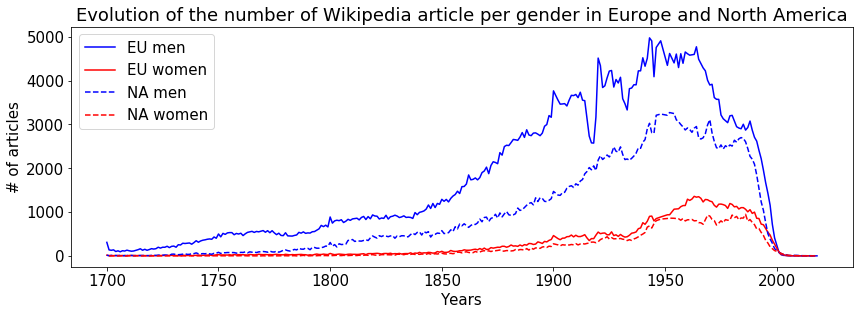

In [53]:
plt.figure(figsize=(14, 15))

plt.subplot(311)
# Plots per gender and regions
plt.plot(clean_dates(EU_m)['BirthYear'], (clean_dates(EU_m)['count']), '-b',
         clean_dates(EU_w)['BirthYear'], (clean_dates(EU_w)['count']), '-r',)

plt.plot(clean_dates(NA_m)['BirthYear'], (clean_dates(NA_m)['count']), '--b',
         clean_dates(NA_w)['BirthYear'], (clean_dates(NA_w)['count']), '--r',)

plt.legend(['EU men', 'EU women', 'NA men', 'NA women'], loc=2)
plt.xlabel('Years'); plt.ylabel('# of articles');
plt.title('Evolution of the number of Wikipedia article per gender in Europe and North America');



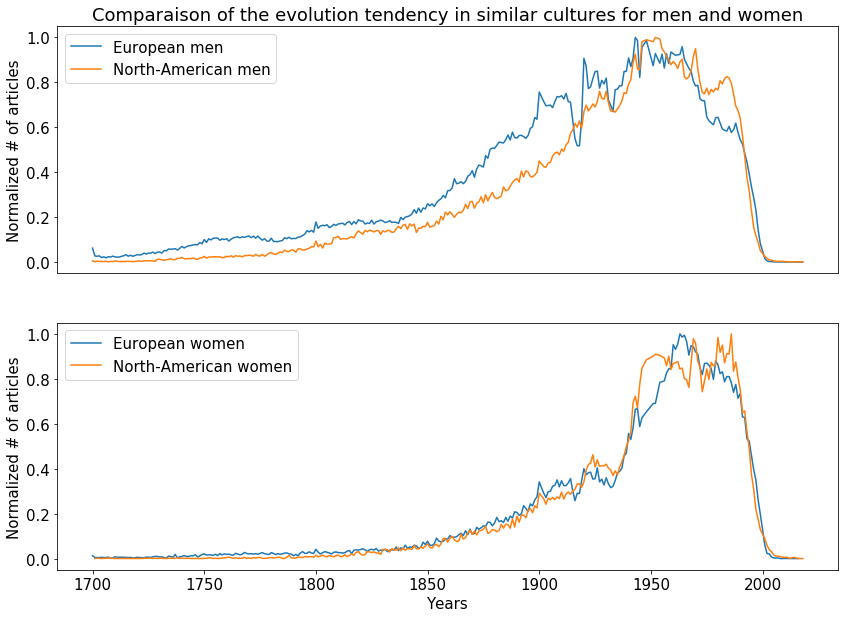

In [55]:
plt.figure(figsize=(14, 10))

# Normalized plots to study the curves' shapes
plt.subplot(211)
plt.plot(clean_dates(EU_m)['BirthYear'], normalize_count(clean_dates(EU_m)),
         clean_dates(NA_m)['BirthYear'], normalize_count(clean_dates(NA_m)))
plt.legend(['European men', 'North-American men'], loc=2)
plt.title('Comparaison of the evolution tendency in similar cultures for men and women')
plt.ylabel('Normalized # of articles'); plt.xticks([])

plt.subplot(212)
plt.plot(clean_dates(EU_w)['BirthYear'], normalize_count(clean_dates(EU_w)),
         clean_dates(NA_w)['BirthYear'], normalize_count(clean_dates(NA_w)))
plt.legend(['European women', 'North-American women'], loc=2)
plt.xlabel('Years'); plt.ylabel('Normalized # of articles');

plt.savefig(FIG_PATH+r"NA_EU_comparaison.png")

The data here shows the evolution of genders on Wikipedia in Western Europe and North America. The evolution for both regions is very similar due to the cultural developement date similarities. Even though the number of articles can lack straight number similarities, when normalized we can see that the evolution curve is the same.


We can also see that that the number of Wikipedia articles is a good indicator of the total population in each region. In the European trace, we can see significant dips in population during both wars. Whereas, the american poplation is mostly unnafected by WW1.

Therefore, we conclude that cultural similarities lead to similarities in gender representaion

### Evolution for different cultures
Now we try and compare the evolution across cultures. The comparaison was made using western data with North-East Asia and muslim countries, in two sets, Magrheb and the Middle-East.

The idea here is to study the shapes of the curve to show their evolution, not the magnitude of the article count. This means that we will here compare the normalized article counts.

In [56]:
NE_AS_m, NE_AS_w = get_humans_w_cit(humans, regions['NE_AS'])
display_coutries(['NE_AS'])

NE_AS :
	- Japan
	- South Korea


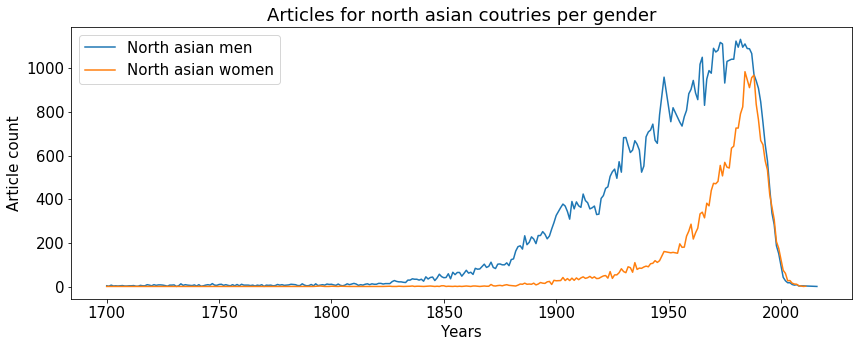

In [57]:
# Data for NE Asia
plt.figure(figsize=(14, 5))
plt.plot(clean_dates(NE_AS_m)['BirthYear'], (clean_dates(NE_AS_m))['count'],
         clean_dates(NE_AS_w)['BirthYear'], (clean_dates(NE_AS_w))['count'])
plt.legend(['North asian men', 'North asian women'])
plt.xlabel('Years'); plt.ylabel('Article count')
plt.title('Articles for north asian coutries per gender');

**Analysis**

This is the first time that we have noticed a behavior quite like this one. Here we can see that for the more recent years, the F/M ratio is very close to one

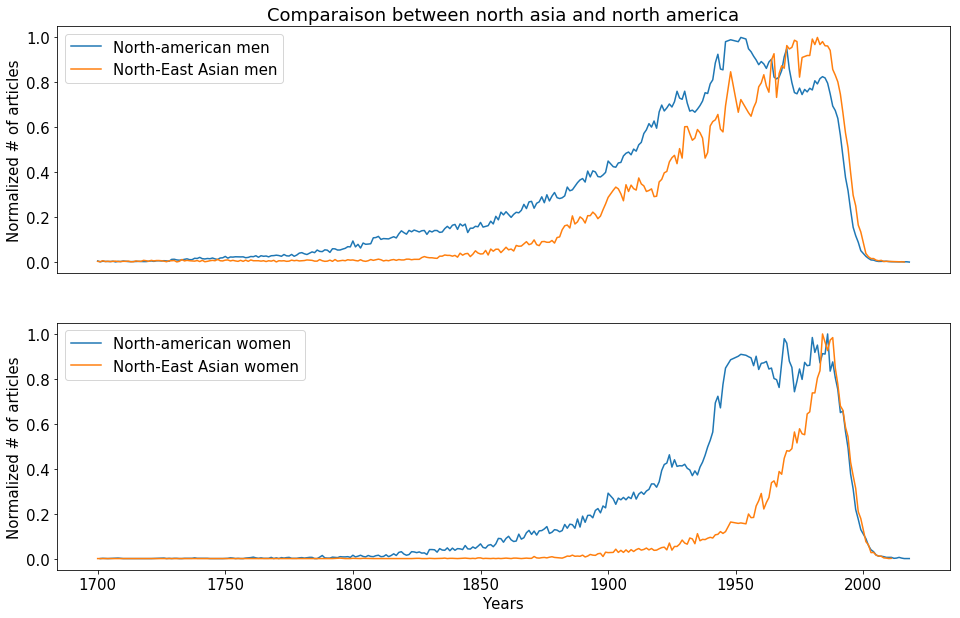

In [59]:
# Curve comparianson for AS and America
plt.figure(figsize=(16, 10))
plt.subplot(211)
plt.plot(clean_dates(NA_m)['BirthYear'], normalize_count(clean_dates(NA_m)),
         clean_dates(NE_AS_m)['BirthYear'], normalize_count(clean_dates(NE_AS_m)))
plt.legend(['North-american men', 'North-East Asian men'])
plt.title('Comparaison between north asia and north america')
plt.ylabel('Normalized # of articles'); plt.xticks([])

plt.subplot(212)
plt.plot(clean_dates(NA_w)['BirthYear'], normalize_count(clean_dates(NA_w)),
         clean_dates(NE_AS_w)['BirthYear'], normalize_count(clean_dates(NE_AS_w)))
plt.legend(['North-american women', 'North-East Asian women'])
plt.xlabel('Years'); plt.ylabel('Normalized # of articles');

plt.savefig(FIG_PATH+r"NA_AS_comparaison.png")

For this culture group (highly developped asian countries) we can see that although, similarly to all the other cultures, women weren't represented at first. The number of articles about them has grown at a huge rate later and has almost reached an equality point.

In [60]:
ME_m, ME_w = get_humans_w_cit(humans, regions['ME'])
MA_m, MA_w = get_humans_w_cit(humans, regions['MA'])
display_coutries(['ME', 'MA'])

ME :
	- Saudi Arabia
	- United Arab Emirates
	- State of Palestine
	- Qatar
	- Israel
	- Lebanon
	- Afghanistan
	- Iraq
	- Jordan
	- Iran
	- Syria
	- Kuwait
	- Bahrain
MA :
	- Morocco
	- Egypt
	- Tunisia
	- Libya
	- Algeria


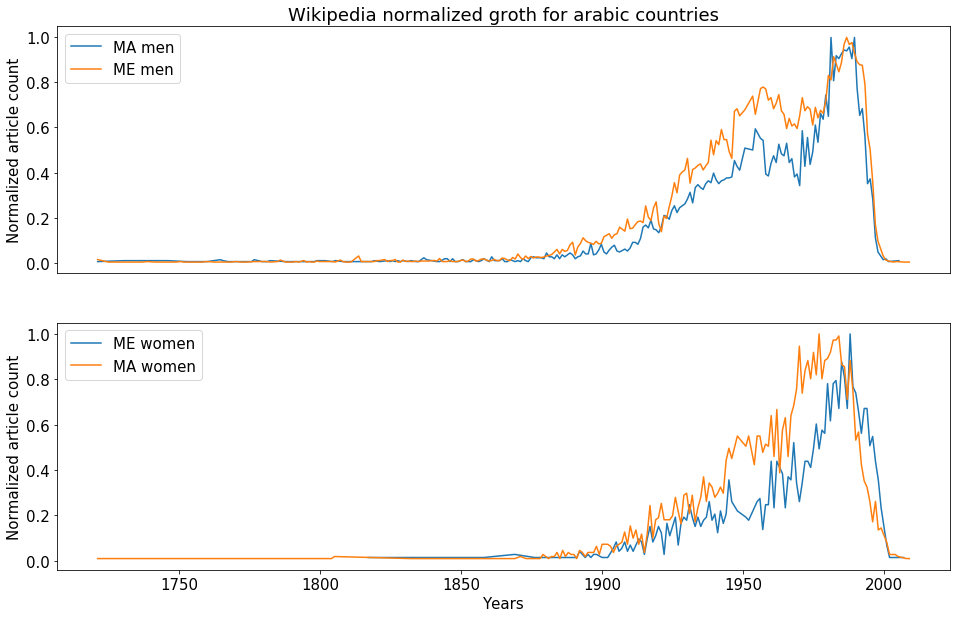

In [61]:
# Compariason between arabic coutries
plt.figure(figsize=(16, 10))
plt.subplot(211)
plt.plot(clean_dates(MA_m)['BirthYear'], normalize_count(clean_dates(MA_m)),
         clean_dates(ME_m)['BirthYear'], normalize_count(clean_dates(ME_m)))
plt.legend(['MA men', 'ME men'])
plt.ylabel('Normalized article count'); plt.xticks([])
plt.title('Wikipedia normalized groth for arabic countries')
plt.subplot(212)
plt.plot(clean_dates(MA_w)['BirthYear'], normalize_count(clean_dates(MA_w)),
         clean_dates(ME_w)['BirthYear'], normalize_count(clean_dates(ME_w)))
plt.legend(['ME women', 'MA women'])
plt.xlabel('Years'); plt.ylabel('Normalized article count');

**Choices for the following plots**

The aim of this part was to comapare the arabic countries to the rest of the world. In this plot we show that the evolution for the middle east ond for maghreb countries are very similar. For this reason, we chose to combine those in order to have more data.

In [62]:
# Copies the lists as to not modify the dict
arabic_regions = regions['ME'].copy() + regions['MA'].copy()
AR_m, AR_w = get_humans_w_cit(humans, arabic_regions)

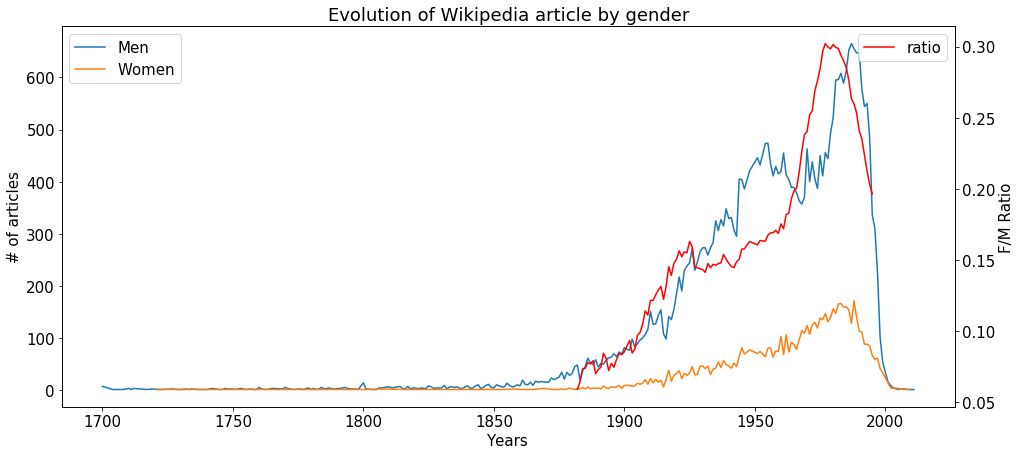

In [64]:
# Removes date with erroneous values
df_women_yr = clean_dates(women_pd_yr)
df_men_yr = clean_dates(men_pd_yr)

fig, ax1 = plt.subplots(); fig.set_size_inches(16, 7)

ax1.plot(clean_dates(AR_m)['BirthYear'], (clean_dates(AR_m))['count'])
ax1.plot(clean_dates(AR_w)['BirthYear'], (clean_dates(AR_w))['count'])

ax1.set_xlabel('Years'); ax1.set_ylabel('# of articles')
ax1.legend(['Men', 'Women'], loc=2);

# Computation of the ratio: 
# Ratio doesn't take into account the values after 1995 because they aren't complete
df_AR = clean_dates(AR_m).merge(clean_dates(AR_w), on='BirthYear', how='inner'
                               ).rename(columns={'count_x':'men', 'count_y':'women'})
df_AR['ratio'] = df_AR.apply(lambda r: r['women']/r['men'], axis=1 )

ax2 = ax1.twinx()
ax2.plot(df_AR[(df_AR['BirthYear'] >= 1872) & (df_AR['BirthYear'] <= 1995)]['BirthYear'], 
         df_AR[(df_AR['BirthYear'] >= 1872) & (df_AR['BirthYear'] <= 1995)]['ratio'].rolling(10).mean(), '-r')
ax2.legend(['ratio'], loc=1)
ax2.set_ylabel('F/M Ratio')
plt.title('Evolution of Wikipedia article by gender');
plt.savefig(FIG_PATH+r"AR_men_women.png")

**Analysis**

We can show here that similarly to the first plot the amount of women increases for the later part of the plot. Although, compared to the previous plot, the M/F ratio reaches its max in the mid 70s. After this period, the ratio starts going down again. This is a strange behavior that we have not seen before in the other analyzed countries. 

One hypothesis for this could be the fact that during a period of time in the 70s some coutries like Turkey and Iran had periods of secularism where women had more freedom that they currently have.

## Analysis of women disitribution through wikipedia articles languages

In [65]:
humans = humans.select(F.col('BirthYear').alias('Birth'), F.col('BirthPlace'), F.col('Citizenships'), F.col('Death'), F.col('Gender'), F.col('Id'), F.col('Name'), F.col('Occupations'), F.col('Sitelinks'))

In [66]:
humans.filter("'Birth' > 1700 and 'Birth' < 2018")

DataFrame[Birth: bigint, BirthPlace: string, Citizenships: array<string>, Death: bigint, Gender: string, Id: string, Name: string, Occupations: array<string>, Sitelinks: array<string>]

We want to compare the number of articles for women and men for each wikipedia language. To do so we use the sitelinks column of our humans dataframe that we explode and then group them by sitelink while counting the number of man and woman during the aggregation and create a new dataframe with the result.

In [67]:
sitelinks_gender = spark.createDataFrame(humans.withColumn('sitelinks', F.explode('sitelinks'))
                                         .groupBy('sitelinks').agg(F.collect_list("Gender")).rdd
                                         .map(lambda r: Row(sitelinks = r[0], Male = r[1].count('male'), 
                                                                              Female = r[1].count('female')))
                                         .filter(lambda r: r[2].endswith('wiki')))  #
                


In [68]:
sitelinks_pd = sitelinks_gender.toPandas()
sitelinks_pd['Total'] = sitelinks_pd[['Male','Female']].sum(axis=1, numeric_only =True)
sitelinks_pd['Ratio_w'] = sitelinks_pd['Female'].div(sitelinks_pd['Total'])
sitelinks_pd = sitelinks_pd[sitelinks_pd['Total']>1000]

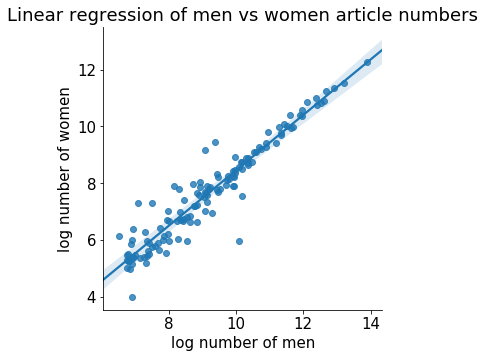

In [69]:
# now plot the scatter of number of men vs women in each wikipedia language.

# We create columns with the log of the number for a log-log plot
sitelinks_pd['log number of men'] = sitelinks_pd['Male'].apply(np.log)
sitelinks_pd['log number of women'] = sitelinks_pd['Female'].apply(np.log)

# create scatter plot with linear regression with 99.99% confidence interval calculated by bootstrapping
ax = sns.lmplot(x='log number of men',y='log number of women', data=sitelinks_pd, fit_reg=True, ci=99.99, n_boot=10000)
ax.set(title='Linear regression of men vs women article numbers')


In [70]:
# Calculating pearson correlation coefficient
sitelinks_pd[['Female','Male']].corr(method='pearson' )

,Female,Male
Female,1.000000,0.992232
Male,0.992232,1.000000


**Analysis**

Here the slope of the regression curve represent the ratio of woman. We see there are some outliers, especially in lower values (keeping in mind the logarithmic scale) but overall, the distrubution follows. We see that since the pearson coefficient is so high (0.992232) the ratio of women to men is globally not dependant on the language. 

We now plot the ratio of women to get another represention

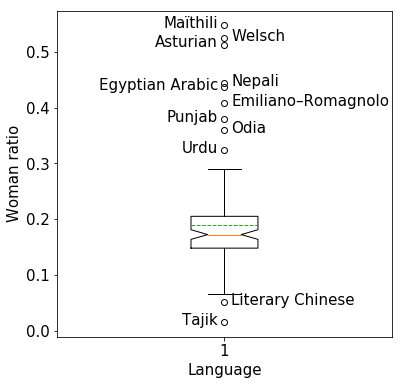

In [71]:
# creating a dictionnary for labeling outliers
dic_language = {'tgwiki': 'Tajik', 'zh_classicalwiki':'Literary Chinese', 'urwiki':'Urdu', 'orwiki':'Odia', 'pawiki':'Punjab',
                'emlwiki':'Emiliano–Romagnolo', 'arzwiki':'Egyptian Arabic', 'newiki':'Nepali', 'astwiki':'Asturian',
                'cywiki':'Welsch', 'maiwiki':'Maïthili'}

# creating a dictionnary with the ratio corresponding to each language for later labeling
dic_sitelinks = dict(zip(sitelinks_pd['Ratio_w'].tolist(), sitelinks_pd['sitelinks'].tolist()))

# creating boxplot with notched 95% confidence interval for the median calculated by boostraping
plt.figure(figsize=(6,6))
ax = plt.boxplot(sitelinks_pd['Ratio_w'].tolist(), notch=True, bootstrap=1000, showmeans=True, meanline=True, widths=0.2)

# get outliers data 
labels = ax['fliers'][0].get_data()
labels[1].sort()
xfliers = labels[0].tolist()
yfliers = labels[1].tolist()

#iterate over each outliers and adds label of its language
for i, y in enumerate(yfliers):
    if i%2 == 0:
        plt.text(xfliers[i]-0.02 , y -0.005 , dic_language[dic_sitelinks[y]], horizontalalignment='right')
    else:
        plt.text(xfliers[i]+0.02 , y-0.005  , dic_language[dic_sitelinks[y]])
plt.xlabel('Language')
plt.ylabel('Woman ratio')
plt.savefig('boxplot_languages.png')

We can see that the median of the ratio of women is around 0.18 and except for the few outliers all the ratio are distributed between 0.3 and 0.1 with the quartiles being at about 1.5 and 2.1. 
By examining the outliers, we see that they are all fairly rare languages and thus the random variations could explain their ratio

## Analysis of gender inequalities through occupations

We now want to investigate if the distribution of women and men is different in different fields of occupations and if we can highlight some changes through time.


In [76]:
#
def create_bins(df, bin_size):
    """
    from the human dataframe, takes the floor of the division of the birth year by the bin_size 
    in order to create bins of bin_size years.
    IN: spark dataframe df
        int bin_size
    """
    df_bin = spark.createDataFrame(df.rdd.map(lambda r: Row(Birth = r[0]//bin_size,
                                                            Birthplace = r[1], 
                                                            Citizenship = r[2], 
                                                            Death = r[3], 
                                                            Gender = r[4], 
                                                            Id = r[5], 
                                                            Name = r[6], 
                                                            Occupations = r[7])))
    return df_bin


def get_humans_w_occ(df):
    """
    From a human dataframe, groups the humans by occupations and by year of birth for men and women
    
    IN: Dataframe of humans and their attributes
    
    OUT: Two pandas dataframes for men and women of given occupations for each year / bin of years
    """
    
    citizens = df.select("Id", "Birth", "Citizenship", "Occupations", "Gender") \
                 .withColumn("Citizenship", F.explode("Citizenship"))
    
    # separate men and women in 2 different dataframe to facilitate the operations
    men = citizens.filter("Gender == 'male'")
    women = citizens.filter("Gender == 'female'")
    
    # explode occupations, groups the row by birth and aggregate with a list of count of occurence of each occupation for one birth date
    # Then explode occupation occurence list and filter all occupations that have less than 5 people.
    men_occ = spark.createDataFrame(spark.createDataFrame(men.select('Birth', 'Occupations')
                                            .withColumn('Occupations', F.explode('Occupations'))
                                            .groupBy("Birth").agg(F.collect_list("Occupations")) 
                                            .rdd.map(lambda r: Row(Occupations = Counter(r[1]).most_common(),
                                                                   Birth = r[0],)))
                                        .withColumn('Occupations', F.explode('Occupations'))
                                        .rdd.map(lambda r: Row(Birth = r[0], Occupations = r[1][0], number = r[1][1]))).filter('number > 5')
    
    women_occ = spark.createDataFrame(spark.createDataFrame(women.select('Birth', 'Occupations')
                                            .withColumn('Occupations', F.explode('Occupations'))
                                            .groupBy("Birth").agg(F.collect_list("Occupations")) 
                                            .rdd.map(lambda r: Row(Occupations = Counter(r[1]).most_common(),
                                                                   Birth = r[0],)))
                                        .withColumn('Occupations', F.explode('Occupations'))
                                        .rdd.map(lambda r: Row(Birth = r[0], Occupations = r[1][0], number = r[1][1]))).filter('number > 5')

    
    #putting labels instead of numeric id 
    women_occ = spark.createDataFrame(women_occ.rdd.filter(lambda r: r[1] in dict_occ.keys())
                                       .map(lambda r: Row(Women_count = r[2],
                                                          Birth = r[0],
                                                          Occupation = dict_occ[r[1]])))
    men_occ = spark.createDataFrame(men_occ.rdd.filter(lambda r: r[1] in dict_occ.keys())
                                       .map(lambda r: Row(Men_count = r[2],
                                                          Birth = r[0],
                                                          Occupation = dict_occ[r[1]])))
    # converts the dataframe to pandas
    women_occ_pd = women_occ.toPandas()
    men_occ_pd = men_occ.toPandas()
    
    return men_occ_pd, women_occ_pd

def return_category(x, dic):
    for key, vals in dic.items():
        if x in vals:
            return key
       
    return 'others'

In [77]:
# We group humans by decade in order to have enough humans fo each time point to have significant result
bins = create_bins(humans, 10)

In [78]:
# Loading of the dictionnary to group the occupations by category
dict_cat = {}
with open(os.path.join("dict", "categories.txt"), mode='rt') as f:
    f.read(3)
    for line in f:
        dict_cat.update(eval(line.strip()))
        
# Imports a dictionary for labeling the IDs of the occupations 
dict_occ = {}
with open(os.path.join("dict","occupations_to_name.json"), mode='rt') as f:
    for line in f:
        dict_occ.update(eval(line.rstrip('\n')))

In [79]:
#create the dataframes with the occupations counts for women and for men.
men_occ_pd1, women_occ_pd1 = get_humans_w_occ(bins)

In [80]:
men_occ_pd, women_occ_pd = men_occ_pd1, women_occ_pd1

# create a new category column which indicates to which category each occupation belongs using the dictionnary loaded previously.
men_occ_pd['category'] = men_occ_pd['Occupation'].apply((lambda x: return_category(x, dict_cat)))
women_occ_pd['category'] = women_occ_pd['Occupation'].apply((lambda x: return_category(x, dict_cat)))

# group by category and birth bin so as to have for each bin a count of the number of people appearing in each category
men_pd = men_occ_pd.groupby(['Birth','category']).sum()
women_pd = women_occ_pd.groupby(['Birth','category']).sum()

# merging the 2 dataframes
occ_all_pd = pd.merge(women_pd,men_pd, how='outer', left_on = ['Birth', 'category'], right_on = ['Birth', 'category'], sort = True).groupby(['Birth','category']).sum()

#creating new columns for total count and ratio of woman
occ_all_pd['Total'] = occ_all_pd[['Women_count', 'Men_count']].sum(axis=1, numeric_only =True)
occ_all_pd['Ratio_w'] = occ_all_pd['Women_count'].div(occ_all_pd['Total'])
occ_all_pd.reset_index(inplace=True)
# dropping useless columns
occ_all_pd.drop(['Women_count', 'Men_count', 'Total'], axis=1, inplace=True) 

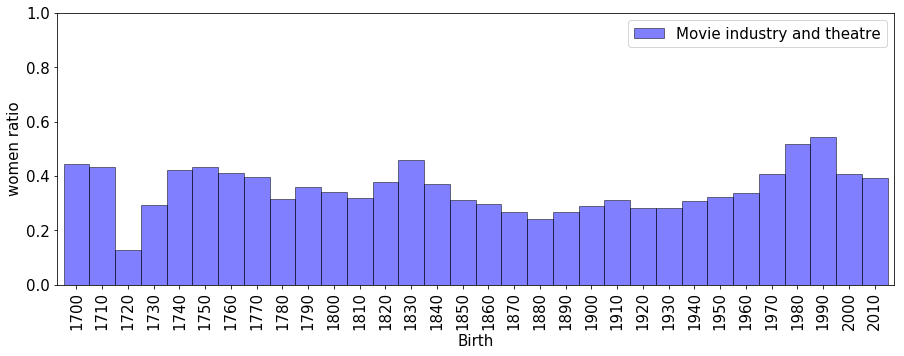

In [81]:
# only keeping people after 1700. Since we bined by 10 years, we actually take 170 as smallest birth
occupations = occ_all_pd[occ_all_pd['Birth'] >=170] 
# multiplying by 10 to come back to a normal year format
occupations['Birth'] = occupations['Birth']*10

# pivoting table to represent the data in a way that makes it easier to plot and correcting the indexing
occupations = pd.pivot_table(occupations, index=['Birth'], columns=['category'])
occupations.fillna(0, inplace=True)
occupations.columns = occupations.columns.get_level_values(1)

# bar plot for the Movie and theater industry
occupations.reset_index().plot.bar('Birth','Movie industry and theatre', color='b',alpha=0.5, width=1.0, edgecolor='black', ylim = (0,1),figsize=(15,5))
plt.ylabel('women ratio')
plt.savefig('movie_industry.png')

**Analysis**

We first look at movie and theatre industry since it seems to be the unique category of occupations that shows some parity for all the period observed. Though it is unique, this distribution of ratio is not necessarily surprising. There was never really discrimination against actress, in the contrary, they are as needed as actors. The other related job, like director or playwright for instance, may see some discrimination, but since the bulk of famous people in this category are actors, we do no see much inequality there.

We can now look at all other categories

In [ ]:
occupations.drop('Movie industry and theatre', axis=1, inplace=True)

In [ ]:
# now we create a plot for all other occupations
cats = [cat for cat in occupations.columns.tolist()]
palette = Category20[15]

def ridge(category, data, scale=1):
    return list(zip([category]*len(data), scale*data))

x = np.linspace(1700,2010,32)

p = figure(x_range=(1800, 1980), y_range=cats)

source = ColumnDataSource(data=dict(x=x))

for i, cat in enumerate(occupations):
    y = ridge(cat, occupations[cat].values)
    source.add(y, cat)
    p.patch('x', cat, color=palette[i], alpha=0.7, line_color="black", source=source)

p.xaxis.ticker = [1700, 1750, 1800, 1850, 1900, 1950, 2000]
# yticks = np.hstack([np.linspace(0,1,5).tolist() for i in range(15)])
# p.yaxis.ticker = yticks

p.axis.major_label_text_font_size = "10pt"
p.y_range.range_padding = 0.01
output_notebook()
save(p)

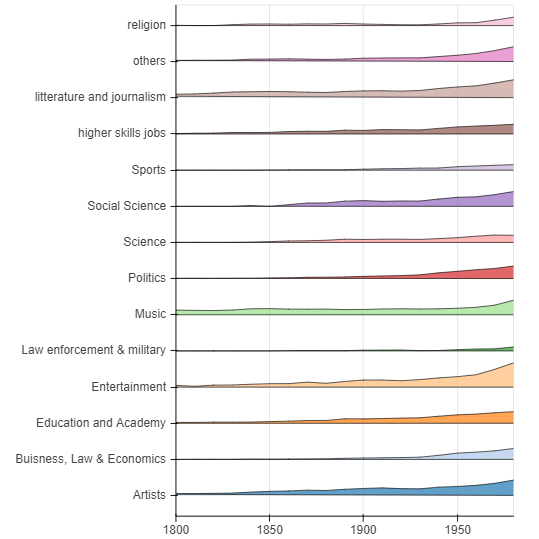

In [1]:
from IPython.display import Image
Image("bokeh_plot.png")

We see on this plot that the for every category, the ratio of women starts low and increases slowly, with a faster increase starting from the 1940's. The height of each box represent a ratio of one, thus we see that there are a few categories where parity is reached: litterature and journalism, social science with only entertainment haveing a ratio that is noticeably higher than 0.5. Most categories are still below a ratio but the trends looks to be going the right way for all of them. Even in categories that were exclusively masculine until recently like religion or military / law inforcement, the ratio is going up steadily. 


## Discussion 

Thgrough these analysis, we see that wikidata can be used to highlight trends in gender equality. We could highlight that depending on the geographic / cultural region, we saw the same disparities as what we expected for instance that women are less represented in arabic countries in general compared to Europe or North America. These last two, as we expected since they are very close culturally, showed the same trends and distributions. However even for there region, though the ratio of women increases exponentially, there is still a lot more men being featured hinting that equality hasn't been reached yet or that if it has, it is not yet showing on wikidata. The only region where there was the same number of women than men was in Japan. 

Regarding the languages of the articles, we showed that there didn't seem to be significant difference between them. From this we can infer that the gender representation differences between regions are not due to gender bias in recording them, but are based on real inequalities that are reflected. 

Through the occupations, we see that, as the the global trend, every occupations tends towards equality. This corroborates the shift of mentality of the modern age in which women are not considered only as housewives but as equal to men and contributing to society in the same way. 

